In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
from matplotlib.figure import figaspect
import matplotlib.gridspec as gridspec
from utility.data import get_dataset_info, map_dataset_name, map_strategy_name
import config as cfg
import itertools

# Set Matplotlib style
matplotlib_style = 'default'
import matplotlib.pyplot as plt
plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'large',
    'axes.titlesize': 'x-large',  # Set larger title size
    'font.size': 14.0,
    'legend.fontsize': 'medium',
})

# Define the custom colors using RGB
dimGreen = (0.0, 0.8, 0.0)  # RGB for dim green
dimRed = (0.8, 0.0, 0.0)    # RGB for dim red

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load results
results = pd.read_csv(Path.joinpath(cfg.RESULTS_DIR, "semisynthetic_results.csv"))

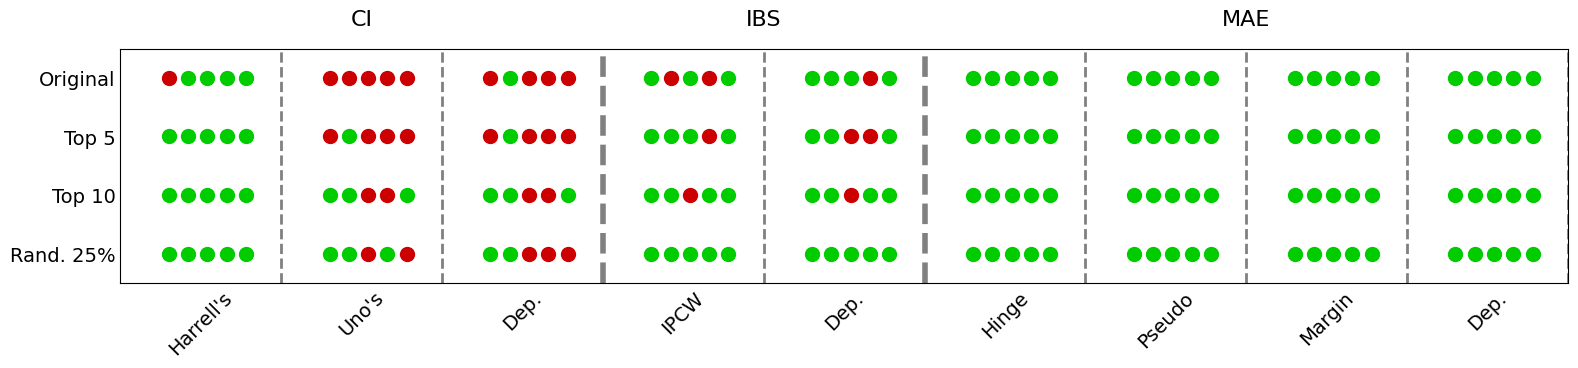

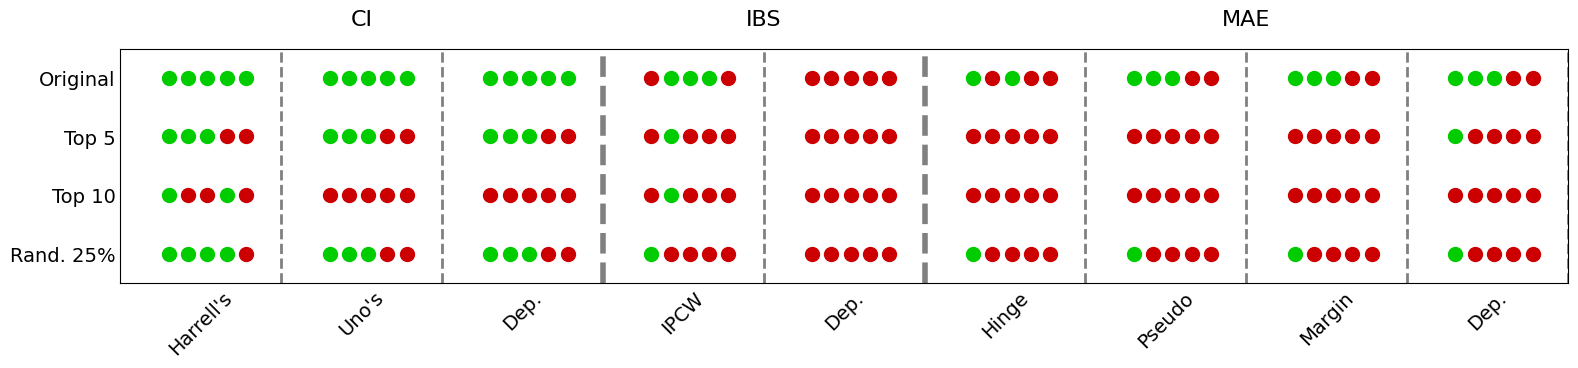

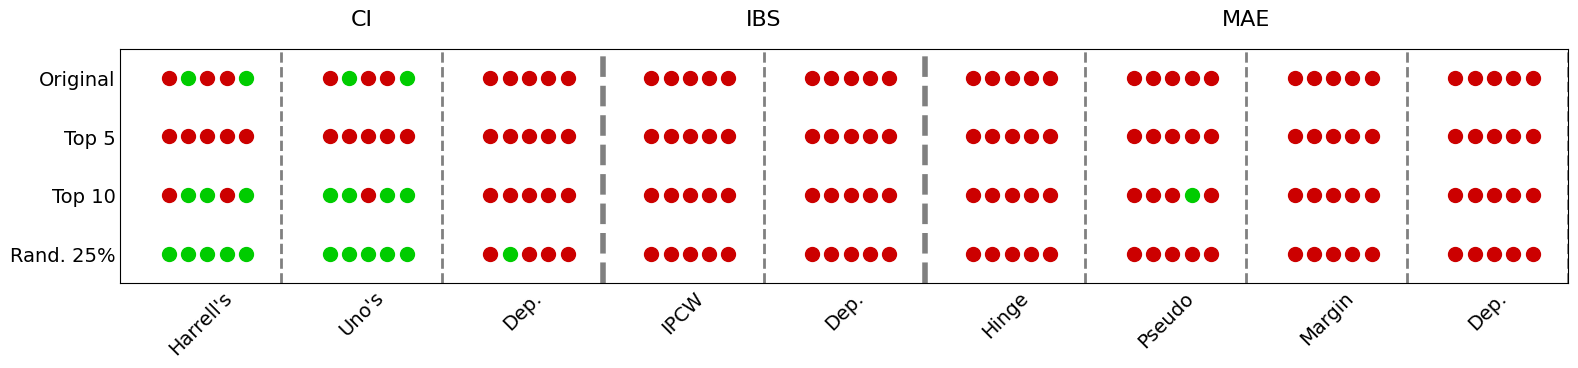

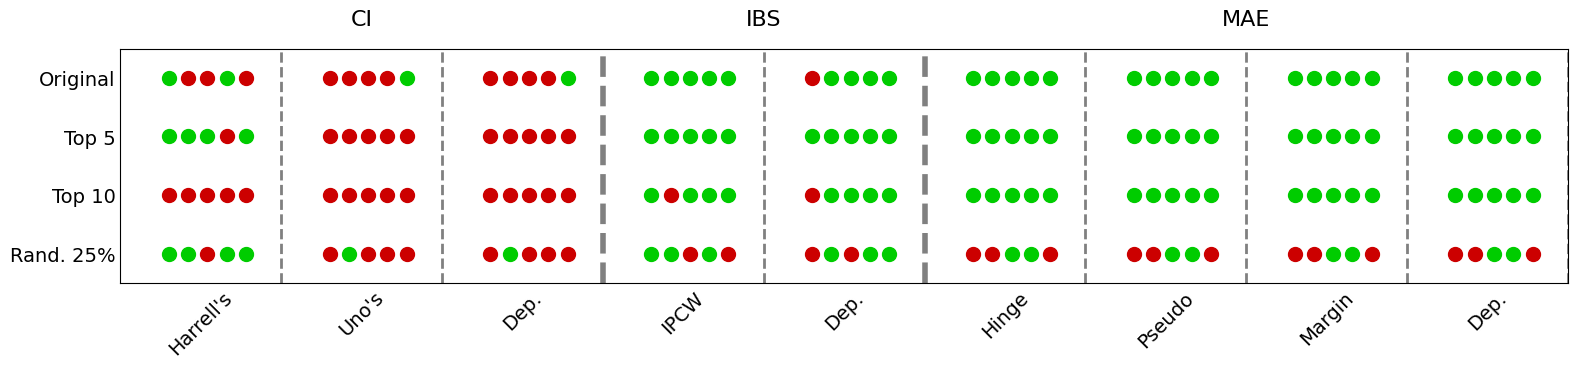

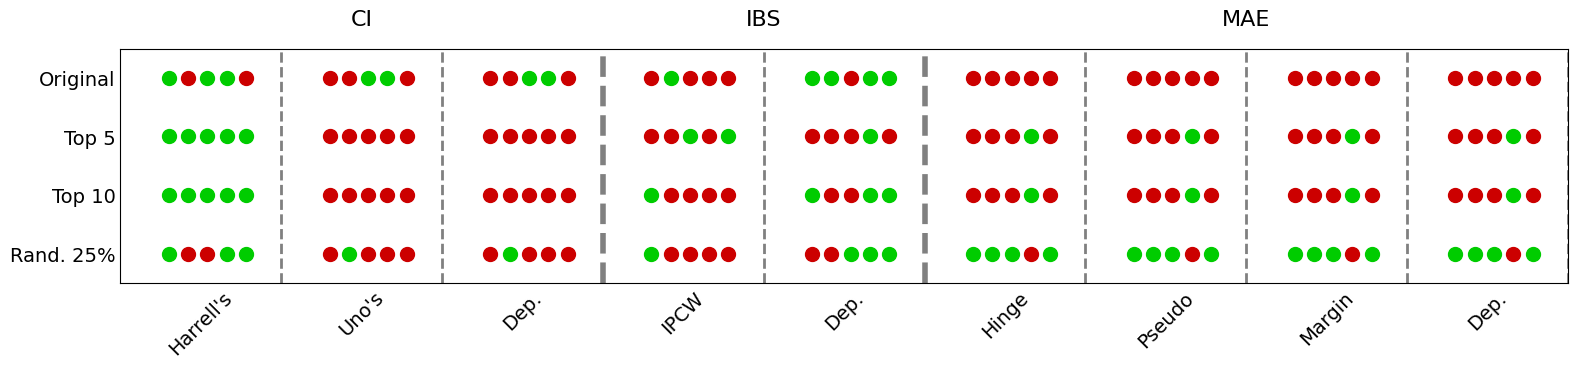

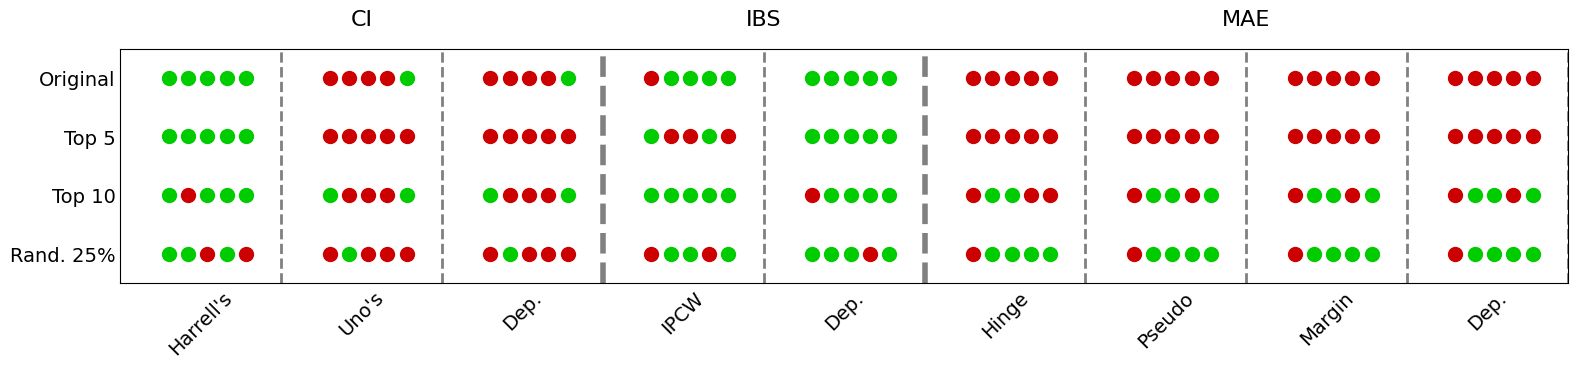

In [2]:
# Define metrics
metrics = ["CIHarrell", "CIUno", "CIDepIPCW", "IBSIPCW", "IBSDepBG",
           "MAEHinge", "MAEPseudo", "MAEMargin", "MAEDepBG"]

datasets = ["metabric", "mimic_all", "mimic_hospital", "seer_brain", "seer_liver", "seer_stomach"]
strategies = ['random_25', 'top_10', 'top_5', 'original']
model_names = ["CoxPH", "GBSA", "RSF", "DeepSurv", "MTLR"]
seeds = [0, 1, 2, 3, 4]

strategy_mapping = {
    "original": "Original",
    "top_5": "Top 5",
    "top_10": "Top 10",
    "random_25": "Rand. 25%",
}

metric_mapping = {
    "CIHarrell": "Harrell's",
    "CIUno": "Uno's",
    "CIDepIPCW": 'Dep.',
    "IBSIPCW": "IPCW",
    "IBSDepBG": "Dep.",
    "MAEHinge": "Hinge",
    "MAEPseudo": "Pseudo",
    "MAEMargin": "Margin",
    "MAEDepBG": "Dep.",
}

# Define metric groups
metric_to_group = {
    **dict.fromkeys(["CIHarrell", "CIUno", "CIDepIPCW"], "CI"),
    **dict.fromkeys(["IBSIPCW", "IBSDepBG"], "IBS"),
    **dict.fromkeys(["MAEHinge", "MAEPseudo", "MAEMargin", "MAEDepBG"], "MAE"),
}

top_k = 3

for dataset in datasets:

    # Calculate ranking
    rank_results = {}
    for strategy, metric_name in itertools.product(strategies, metrics):
        get_metric_group = lambda metric: metric_to_group.get(metric, "Unknown group")
        metric_group = get_metric_group(metric_name)
        n_correct = 0
        for seed in seeds:
            metric_results = results.loc[(results['Dataset'] == dataset) & (results['Strategy'] == strategy) & (results['Seed'] == seed)]
            rank_idx = metric_results[f'{metric_group}True'].values.argsort()
            metric_idx = metric_results[metric_name].values.argsort()
            matches = np.sum(rank_idx[:top_k] == metric_idx[:top_k]) # match the models
            fraction = matches / top_k
            if fraction == 1:
                rank_results[(strategy, metric_name, seed)] = True
            else:
                rank_results[(strategy, metric_name, seed)] = False

    # Set up the plot
    fig, ax = plt.subplots(figsize=(16, 4))

    # Plot for each strategy, metric combination, and seed
    for i, strategy in enumerate(strategies):  # Iterate through ordered strategies
        for j, metric_name in enumerate(metrics):
            for k, seed in enumerate(seeds):
                # Get the result for the current strategy, metric_name, and seed
                correct = rank_results.get((strategy, metric_name, seed), False)
                
                # Plot the correct dot (green) or incorrect dot (red)
                color = dimGreen if correct else dimRed
                
                # Position the dots progressively to the right for each seed (shift by 0.2 for each seed)
                ax.scatter(j + k * 0.12 - 0.2, i, color=color, s=100, marker='o')

    # Set labels and ticks
    mapped_metrics = [metric_mapping.get(metric, metric) for metric in metrics]
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(mapped_metrics, rotation=45)

    # Apply the mapping to y-axis labels
    mapped_strategies = [strategy_mapping.get(strategy, strategy) for strategy in strategies]
    ax.set_yticks(range(len(strategies)))
    ax.set_yticklabels(mapped_strategies)

    # Add vertical lines between metric groups
    metric_groups = ["CI", "IBS", "MAE"]  # Define the metric groups
    group_positions = [3, 5] # Add vertical lines between group 0-1 and 1-2 (in between the metrics)
    for pos in group_positions:
        ax.axvline(x=pos - 0.5, color='gray', linestyle='--', linewidth=4)  # Add the vertical line
        
    group_positions = [1, 2, 4, 6, 7, 8, 9, 11] # Add vertical lines between group 0-1 and 1-2 (in between the metrics)
    for pos in group_positions:
        ax.axvline(x=pos - 0.5, color='gray', linestyle='--', linewidth=2)  # Add the vertical line

    # Adjust the placement of dots to be centered above the x-ticks
    for j in range(len(metrics)):
        ax.scatter(j, len(strategies) - 3, color='white', s=0)  # Add empty scatter at the exact x-tick positions

    # Add titles for each metric group
    group_titles = ["CI", "IBS", "MAE"]
    group_start_positions = [0, 3, 4.5]  # Start positions of each group
    group_widths = [2, 1, 4]  # Widths of each group
    for i, (start, width, group_title) in enumerate(zip(group_start_positions, group_widths, group_titles)):
        ax.text(start + width / 2, 4, group_title, fontsize=16, ha='center', va='center')
        
    # Adjust the plot limits to add padding inside the grid
    ax.set_xlim(-0.5, len(metrics) - 0.5)  # Add padding to the x-axis limits
    ax.set_ylim(-0.5, len(strategies) - 0.5)  # Add padding to the y-axis limits

    plt.tick_params(axis='y', which='both', length=0)
    plt.tick_params(axis='x', which='both', length=0)

    plt.tight_layout()
    plt.savefig(f"{cfg.PLOTS_DIR}/ranking_error_{dataset}.pdf", format='pdf', bbox_inches='tight')
    plt.show()